In [ ]:
require(ggplot2)
require(GGally)
require(reshape2)
require(lme4)
require(compiler)
require(parallel)
require(boot)
require(lattice)

hdp <- read.csv("https://stats.idre.ucla.edu/stat/data/hdp.csv")
hdp <- within(hdp, {
  Married <- factor(Married, levels = 0:1, labels = c("no", "yes"))
  DID <- factor(DID)
  HID <- factor(HID)
})

In [2]:
hdp

tumorsize,co2,pain,wound,mobility,ntumors,nmorphine,remission,lungcapacity,Age,⋯,RBC,BMI,IL6,CRP,DID,Experience,School,Lawsuits,HID,Medicaid
<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<fct>,<int>,<fct>,<dbl>
67.98120,1.534333,4,4,2,0,0,0,0.8010882,64.96824,⋯,4.868416,24.14424,3.6989811,8.0864168,1,25,average,3,1,0.6058667
64.70246,1.676132,2,3,2,0,0,0,0.3264440,53.91714,⋯,4.679052,29.40516,2.6274806,0.8034876,1,25,average,3,1,0.6058667
51.56700,1.533445,6,3,2,0,0,0,0.5650309,53.34730,⋯,5.005862,29.48259,13.8961528,4.0341565,1,25,average,3,1,0.6058667
86.43799,1.453300,3,3,2,0,0,0,0.8484109,41.36804,⋯,5.265058,21.55726,3.0080334,2.1258629,1,25,average,3,1,0.6058667
53.40018,1.566348,3,4,2,0,0,0,0.8864910,46.80042,⋯,4.984259,29.81519,3.8906978,1.3493239,1,25,average,3,1,0.6058667
51.65727,1.417868,4,5,2,0,0,0,0.7010307,51.92936,⋯,5.199714,27.10252,1.4182187,2.1946941,1,25,average,3,1,0.6058667
78.91707,1.706632,3,4,2,0,0,0,0.8908539,53.82926,⋯,4.869905,21.11907,2.2932198,8.6079565,1,25,average,3,1,0.6058667
69.83325,1.528726,3,3,3,0,0,0,0.6608795,46.56223,⋯,4.647919,42.47545,4.5756204,0.8383885,1,25,average,3,1,0.6058667
62.85259,1.542961,4,4,3,2,0,0,0.9088714,54.38936,⋯,4.827062,18.68505,8.0302027,7.2261278,1,25,average,3,1,0.6058667


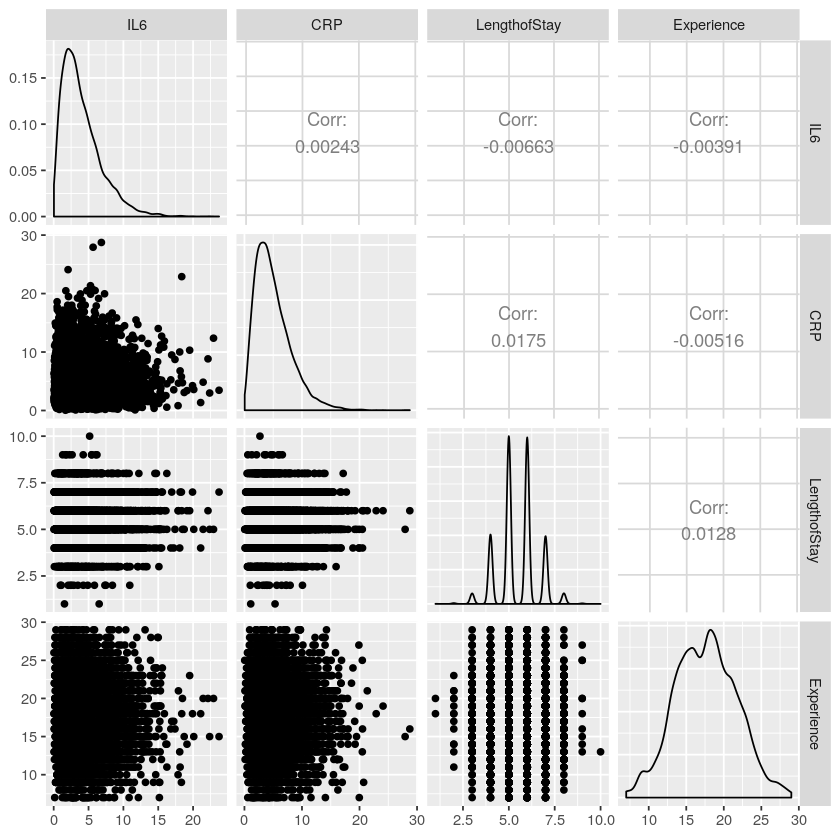

In [3]:
ggpairs(hdp[, c("IL6", "CRP", "LengthofStay", "Experience")])


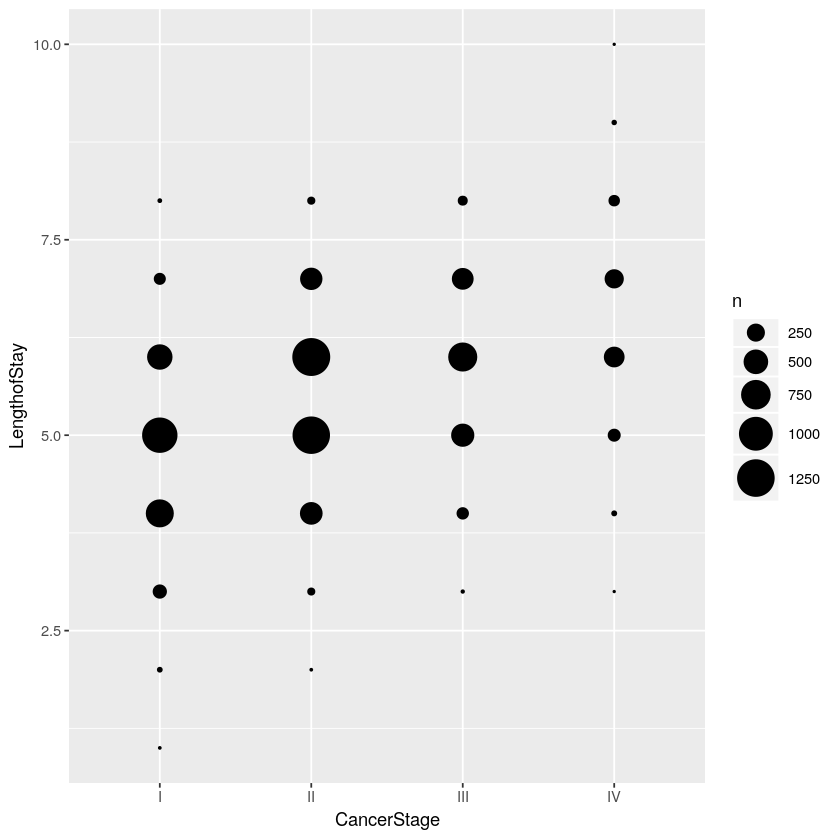

In [4]:
ggplot(hdp, aes(x = CancerStage, y = LengthofStay)) +
  stat_sum(aes(size = ..n.., group = 1)) +
  scale_size_area(max_size=10)

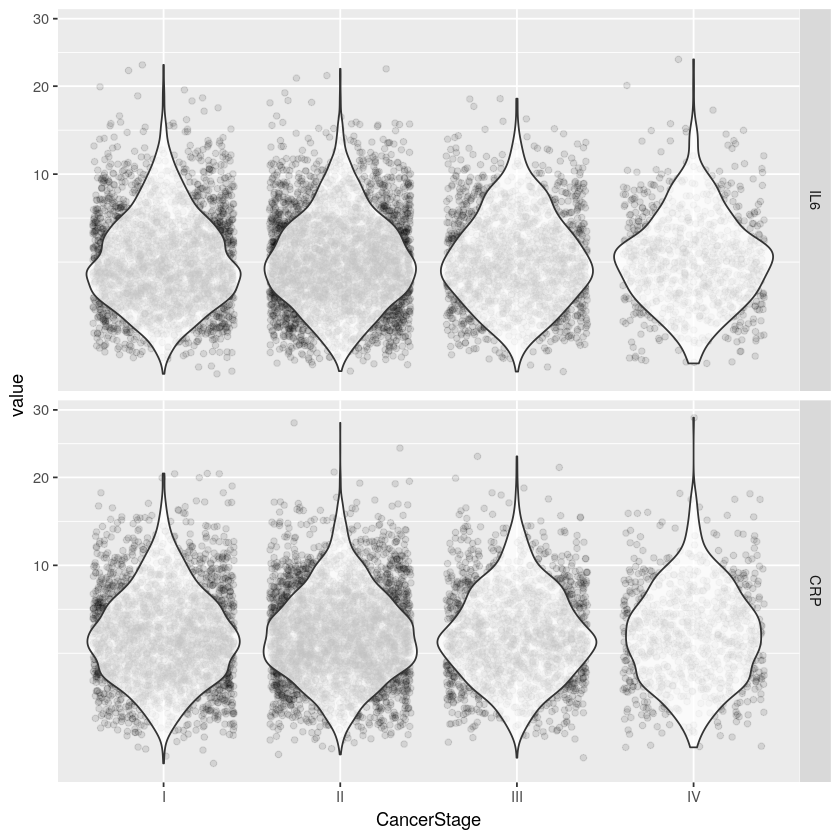

In [5]:
tmp <- melt(hdp[, c("CancerStage", "IL6", "CRP")], id.vars="CancerStage")
ggplot(tmp, aes(x = CancerStage, y = value)) +
  geom_jitter(alpha = .1) +
  geom_violin(alpha = .75) +
  facet_grid(variable ~ .) +
  scale_y_sqrt()


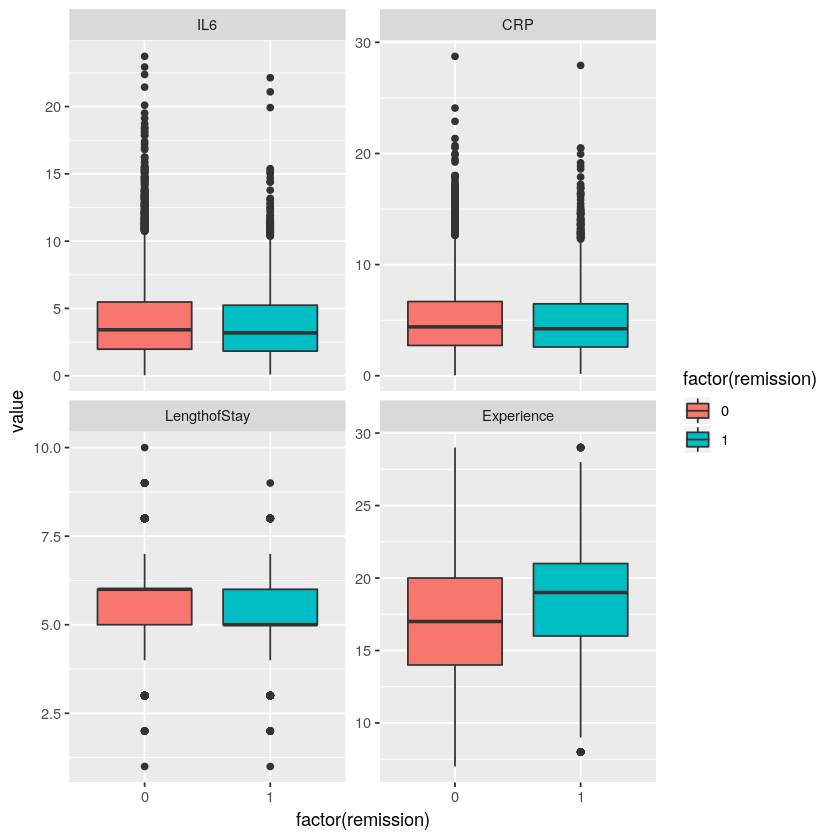

In [6]:
tmp <- melt(hdp[, c("remission", "IL6", "CRP", "LengthofStay", "Experience")],
  id.vars="remission")
ggplot(tmp, aes(factor(remission), y = value, fill=factor(remission))) +
  geom_boxplot() +
  facet_wrap(~variable, scales="free_y")


In [23]:
# tmp

In [24]:
# estimate the model and store results in m
m <- glmer(remission ~ IL6 + CRP + CancerStage + LengthofStay + Experience +
    (1 | DID), data = hdp, family = binomial, control = glmerControl(optimizer = "bobyqa"),
    nAGQ = 10)

# print the mod results without correlations among fixed effects
print(m, corr = FALSE)

In [ ]:
se <- sqrt(diag(vcov(m)))
# table of estimates with 95% CI
(tab <- cbind(Est = fixef(m), LL = fixef(m) - 1.96 * se, UL = fixef(m) + 1.96 *
    se))

In [ ]:
exp(tab)

In [10]:
m3a <- glmer(remission ~ Age + LengthofStay + FamilyHx + IL6 + CRP +
  CancerStage + Experience + (1 | DID) + (1 | HID),
  data = hdp, family = binomial, nAGQ=1)


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.393782 (tol = 0.001, component 1)”

In [13]:
print(m3a, corr=FALSE)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: remission ~ Age + LengthofStay + FamilyHx + IL6 + CRP + CancerStage +  
    Experience + (1 | DID) + (1 | HID)
   Data: hdp
      AIC       BIC    logLik  deviance  df.resid 
 7199.094  7283.703 -3587.547  7175.094      8513 
Random effects:
 Groups Name        Std.Dev.
 DID    (Intercept) 1.9523  
 HID    (Intercept) 0.5486  
Number of obs: 8525, groups:  DID, 407; HID, 35
Fixed Effects:
   (Intercept)             Age    LengthofStay     FamilyHxyes             IL6  
      -1.68819        -0.01493        -0.04468        -1.30658        -0.05686  
           CRP   CancerStageII  CancerStageIII   CancerStageIV      Experience  
      -0.02216        -0.31848        -0.85694        -2.13752         0.12686  
convergence code 0; 1 optimizer warnings; 0 lme4 warnings 


$DID


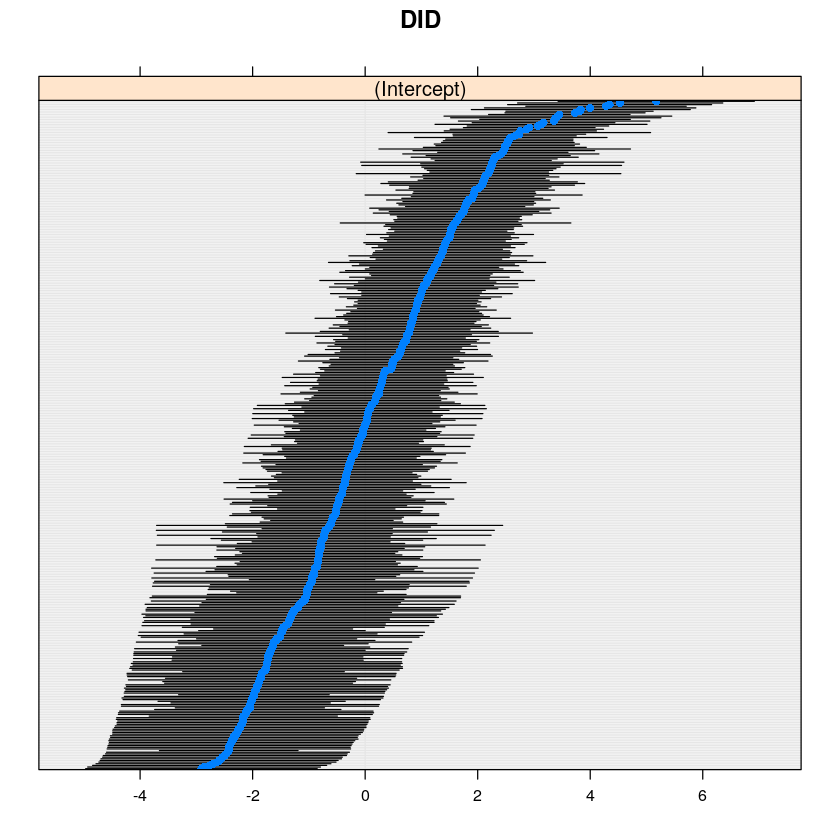

In [14]:
lattice::dotplot(ranef(m3a, which = "DID", condVar = TRUE), scales = list(y = list(alternating = 0)))


$HID


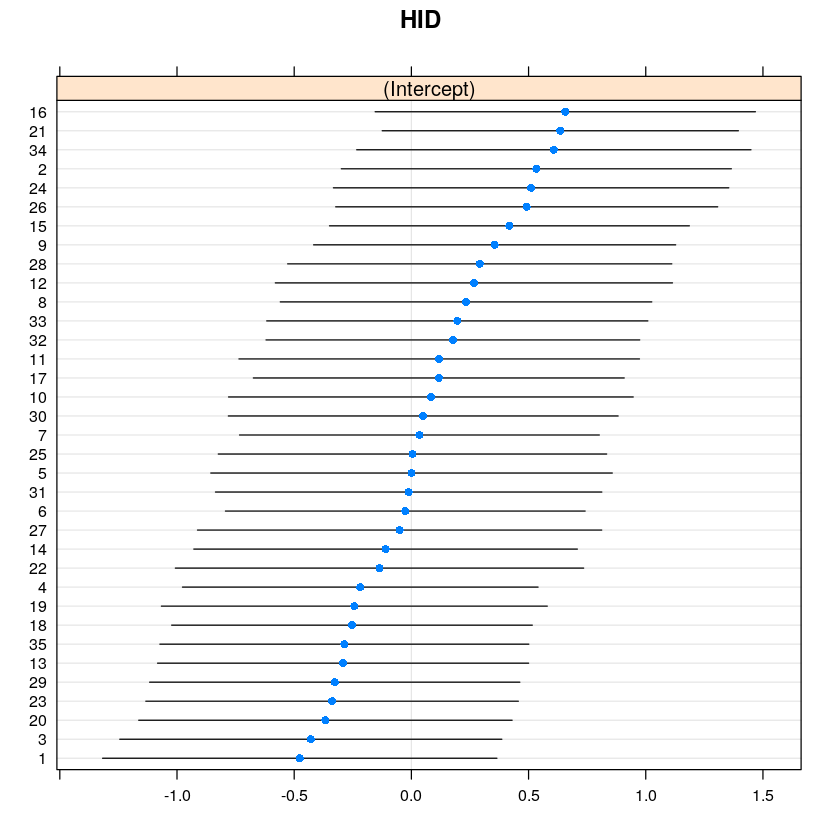

In [15]:
lattice::dotplot(ranef(m3a, which = "HID", condVar = TRUE))


In [16]:
m3b <- glmer(remission ~ Age + LengthofStay + FamilyHx + IL6 + CRP + CancerStage +
    Experience + (1 + LengthofStay | DID) + (1 | HID), data = hdp, family = binomial,
    nAGQ = 1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 1.66455 (tol = 0.001, component 1)”

In [17]:
print(m3b, corr = FALSE)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: remission ~ Age + LengthofStay + FamilyHx + IL6 + CRP + CancerStage +  
    Experience + (1 + LengthofStay | DID) + (1 | HID)
   Data: hdp
      AIC       BIC    logLik  deviance  df.resid 
 7147.749  7246.460 -3559.875  7119.749      8511 
Random effects:
 Groups Name         Std.Dev. Corr 
 DID    (Intercept)  0.5028        
        LengthofStay 0.3729   -0.12
 HID    (Intercept)  0.7319        
Number of obs: 8525, groups:  DID, 407; HID, 35
Fixed Effects:
   (Intercept)             Age    LengthofStay     FamilyHxyes             IL6  
      -0.53628        -0.01524        -0.19065        -1.33815        -0.05866  
           CRP   CancerStageII  CancerStageIII   CancerStageIV      Experience  
      -0.02095        -0.29475        -0.86508        -2.30052         0.10413  
convergence code 0; 1 optimizer warnings; 0 lme4 warnings 


$DID


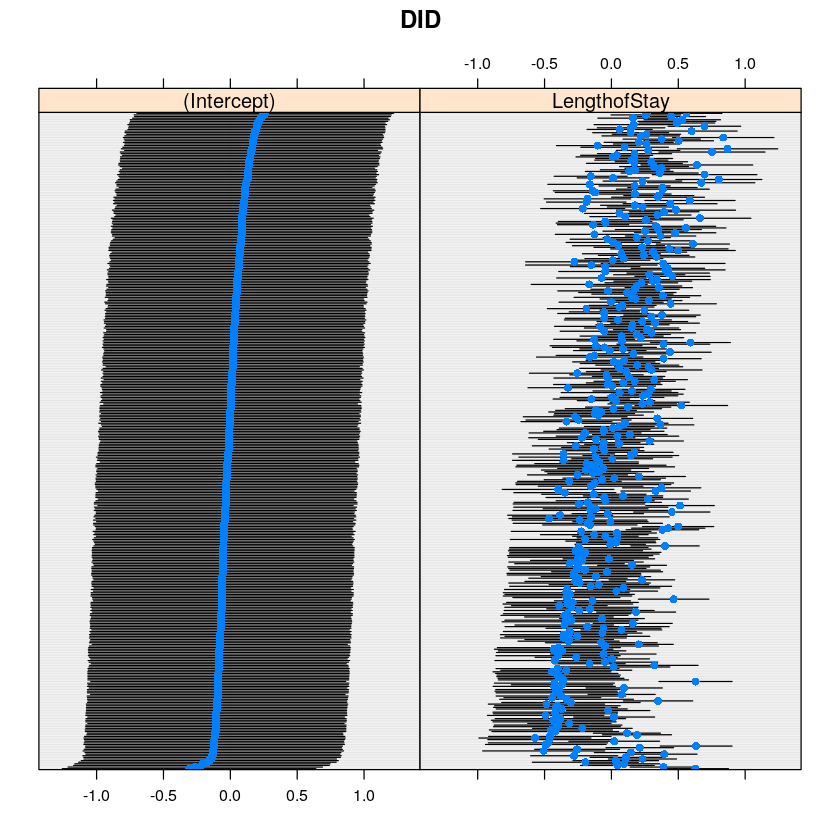

In [18]:
lattice::dotplot(ranef(m3b, which = "DID", condVar = TRUE), scales = list(y = list(alternating = 0)))


$HID


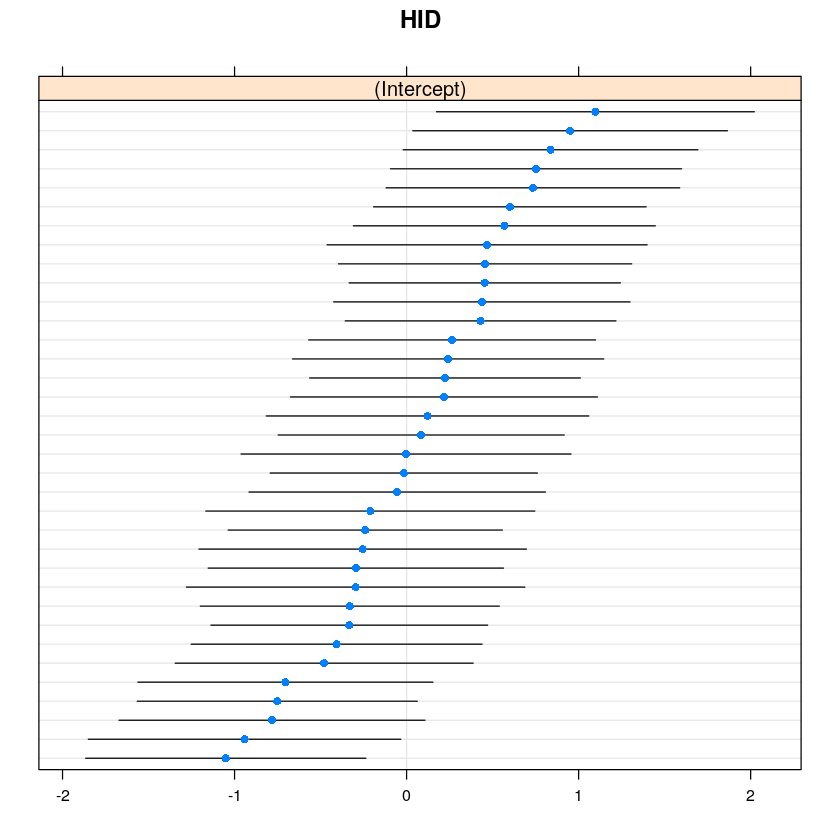

In [21]:
lattice::dotplot(ranef(m3b, which = "HID", condVar = TRUE), scales = list(y = list(alternating = 0)))
